<a href="https://colab.research.google.com/github/sandip01112004/MediScan/blob/main/AI-MediScan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive to access the uploaded file
drive.mount('/content/drive')

# Path to the uploaded zip file
zip_path = '/content/drive/My Drive/eye_disease_dataset.zip'
extract_path = '/content/eye_disease_dataset'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check if the extraction was successful
os.listdir(extract_path)


Mounted at /content/drive


['normal', 'cataract', 'diabetic_retinopathy', 'glaucoma']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
base_dir = '/content/eye_disease_dataset'
categories = ['cataract', 'diabetic_retinopathy', 'normal', 'glaucoma']
img_size = (128, 128)  # Smaller size to manage memory
batch_size = 16  # Smaller batch size to manage memory


In [ ]:
# Create an ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    shear_range=0.2,        # Randomly shear images
    zoom_range=0.2,         # Randomly zoom images
    horizontal_flip=True,   # Randomly flip images horizontally
    validation_split=0.2    # Split data into training and validation sets
)

# Create a training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Create a validation generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)


Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Adjust output layer according to number of categories
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
211/211 [==============================] - 129s 606ms/step - loss: 1.2834 - accuracy: 0.4182 - val_loss: 1.2466 - val_accuracy: 0.4316
Epoch 2/10
211/211 [==============================] - 121s 572ms/step - loss: 1.1271 - accuracy: 0.4932 - val_loss: 1.2098 - val_accuracy: 0.4281
Epoch 3/10
211/211 [==============================] - 133s 630ms/step - loss: 0.9758 - accuracy: 0.5782 - val_loss: 1.2379 - val_accuracy: 0.4590
Epoch 4/10
211/211 [==============================] - 123s 579ms/step - loss: 0.8324 - accuracy: 0.6674 - val_loss: 1.2051 - val_accuracy: 0.4863
Epoch 5/10
211/211 [==============================] - 129s 611ms/step - loss: 0.7550 - accuracy: 0.7076 - val_loss: 1.2631 - val_accuracy: 0.4851
Epoch 6/10
211/211 [==============================] - 119s 566ms/step - loss: 0.6974 - accuracy: 0.7305 - val_loss: 1.4380 - val_accuracy: 0.5042
Epoch 7/10
211/211 [==============================] - 126s 596ms/step - loss: 0.6779 - accuracy: 0.7382 - val_loss: 1.2273 -

In [ ]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Validation accuracy: {test_acc}")


53/53 [==============================] - 19s 355ms/step - loss: 1.2596 - accuracy: 0.5018
Validation accuracy: 0.5017836093902588


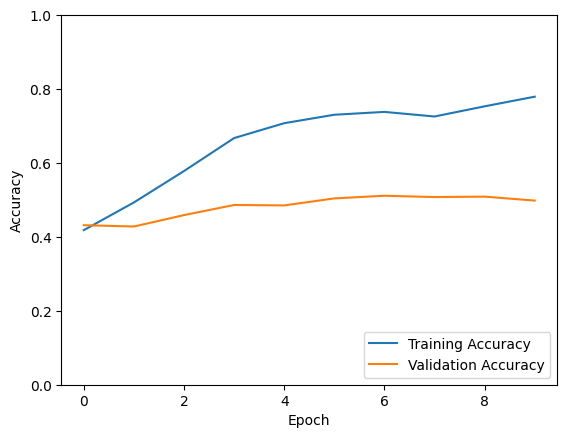

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [ ]:
from google.colab import files
import zipfile
import os

# Upload the ZIP file
uploaded = files.upload()

# Extract the ZIP file
for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('/content/test_images')

# List extracted files
test_images_path = '/content/test_images'
test_image_files = [os.path.join(test_images_path, fname) for fname in os.listdir(test_images_path)]
print(f"Extracted {len(test_image_files)} test images.")


Saving Test.zip to Test (1).zip
Extracted 6 test images.


In [ ]:
import cv2
import numpy as np

# Preprocess images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Load and preprocess all test images
test_images = [preprocess_image(image_path) for image_path in test_image_files]


In [ ]:
# Predict the class of each test image
predictions = [model.predict(image) for image in test_images]

# Get the predicted class indices
predicted_classes = [np.argmax(pred) for pred in predictions]

# Map class indices to category names
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_labels = [class_labels[idx] for idx in predicted_classes]


1/1 [==============================] - 0s 27ms/step


In [ ]:
import pandas as pd

# Create a DataFrame to display the results
results = pd.DataFrame({
    'Image': [os.path.basename(image_path) for image_path in test_image_files],
    'Predicted Label': predicted_labels
})

# Display the results
print(results)


            Image       Predicted Label
0  _0_4517448.jpg              glaucoma
1  _0_4015166.jpg              cataract
2   100_left.jpeg  diabetic_retinopathy
3     8_right.jpg                normal
4  100_right.jpeg  diabetic_retinopathy
5      8_left.jpg                normal
